Импортируем нужные библиотеки

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

from fastai.vision import *

plt.ion()

Монтируем гуглдиск

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Распаковываем архив с картинками

In [0]:
!unzip -q /content/gdrive/My\ Drive/Colab/telegrambot/dataset.zip -d dataset

Удалим папку valid из папки dataset. Там те же картинки что и в трейне, только уменьшеные

In [0]:
!rm -rf /content/dataset/images/valid

формируем датасет: проверочный сет будет составлять 20% от общего, из трансформаций оставляем только изменение яркости картинки в пределах 30% (флипы и повороты негативно сказываются на качество обучения..почему то). размер батча 16 (если ставить большой размер батча, обучение идет быстрее, но колаб ругается, что память вот-вот закончится), размер картинки 300. Все это дело нормализуем.

In [0]:
from pathlib import Path
PATH = Path('/content/dataset/images')
data = ImageDataBunch.from_folder(PATH,valid_pct=0.2, ds_tfms=get_transforms(do_flip=False,flip_vert=False, max_rotate=0,max_lighting=0.3),bs=16, size=300, num_workers=0).normalize(imagenet_stats)

Посмотрим что у нас в батче (выводит случайные картинки плиткой 6х6)

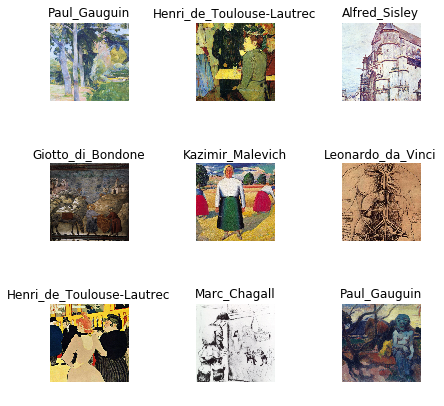

In [0]:
data.show_batch(rows=3, figsize=(6,6))

Загружаем предобученную модель densenet161

In [6]:
model = cnn_learner(data, models.densenet161, metrics=accuracy,callback_fns=ShowGraph)


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:03<00:00, 36512481.90it/s]


Запускаем обучение на 20 эпохах (обучение без Finetune показывает лучше результат)

In [7]:
model.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,time
0,2.391408,1.731849,0.577857,18:26
1,1.417949,1.074382,0.719953,17:28
2,1.137380,0.880821,0.761989,17:25
3,1.109357,0.854319,0.758437,17:21
4,0.980892,0.817709,0.769094,17:23
5,0.817270,0.770705,0.796329,17:23
6,0.695508,0.731748,0.805210,17:33
7,0.683903,0.698011,0.815275,17:21
8,0.503383,0.674473,0.824748,17:33
9,0.480069,0.644956,0.825933,17:17


3 следующие ячейки можно не запускать, прироста качества это не дает. Возможно из за специфики датасета. Стиль одного художника может очень сильно отличатся, например у Малевича есть как абстракция, так и портреты, поэтому даже человеку, который не видел всех картин Малевича не сможет классифицировать картину по нескольким образцам. По всей видимости этот ньюанс сильно портит качество обучения.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.29E-07


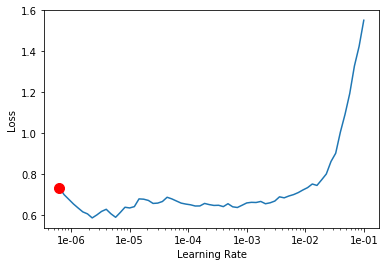

In [0]:
# Здесь мы используем lr_finder, чтобы выбрать скорость обучения
model.lr_find()
model.recorder.plot(suggestion=True)

In [0]:
model.unfreeze()

Подставляем найденный lr и запускаем обучение

In [0]:
from fastai.callbacks import SaveModelCallback 
# используем 1cycle policy подрбнее https://docs.fast.ai/callbacks.one_cycle.html
model.fit_one_cycle(10, 6.31e-07,callbacks=[SaveModelCallback(model, every='epoch', monitor='accuracy', name='model')])

epoch,train_loss,valid_loss,accuracy,time
0,0.591357,0.696303,0.808170,13:58
1,0.632929,0.694893,0.807578,13:53
2,0.578691,0.683132,0.809947,13:53
3,0.568707,0.683944,0.814091,13:55
4,0.573469,0.678552,0.811131,13:50
5,0.577650,0.675257,0.811131,13:45
6,0.555272,0.670619,0.815275,13:43
7,0.584665,0.668814,0.811723,13:41
8,0.593129,0.671724,0.814091,13:43
9,0.594460,0.681911,0.808763,13:41


Посмотрим насколько качественно модель определяет картинки и на каких чащще всего ошибается. 

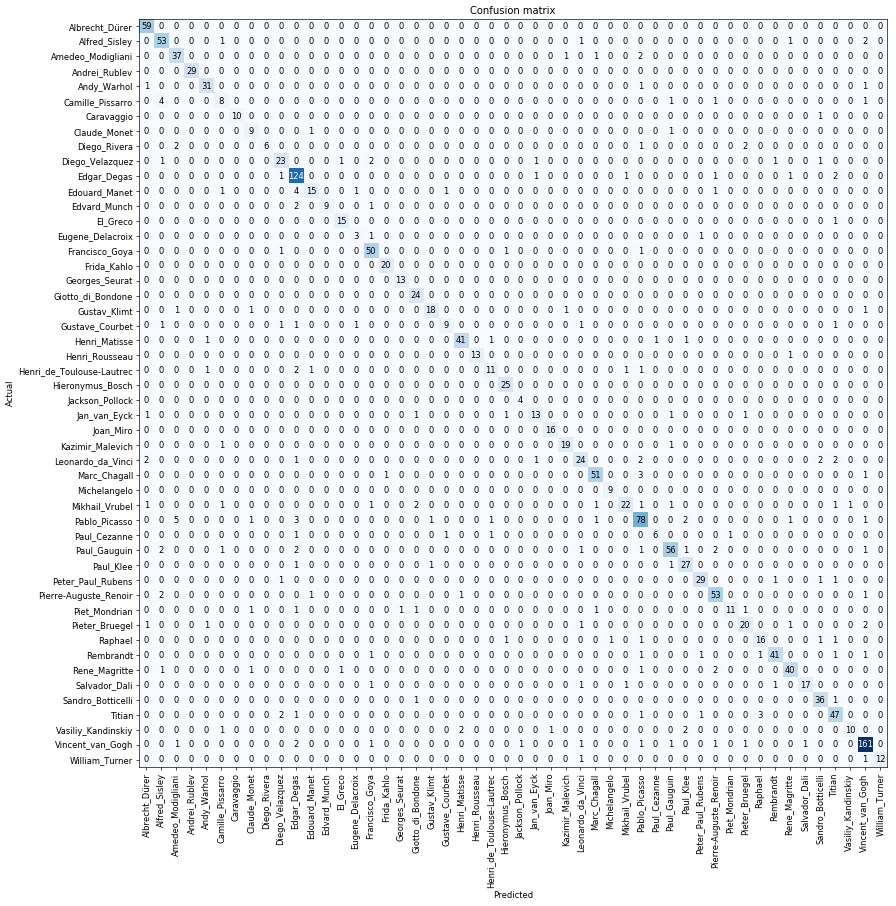

In [8]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix(figsize=(15,15), dpi=60)

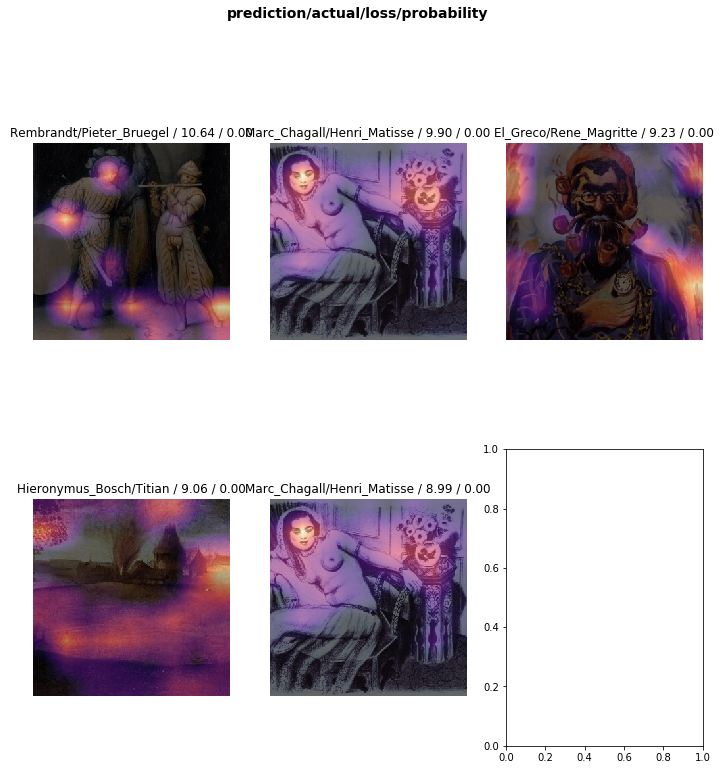

In [0]:
interp.plot_top_losses(5)

Сохраняем веса в файл

In [0]:
model.export()

In [0]:
Далее идет блок для экспериментов с уже обученнной сетью и результатами предсказаний

загружаем веса

In [0]:
model=load_learner('/content/gdrive/My Drive/Colab Notebooks/DLproject/', 'export.pkl')

Загрузим  каккю нибудь картинку, которой нет в датасете и попробуем ее распознать

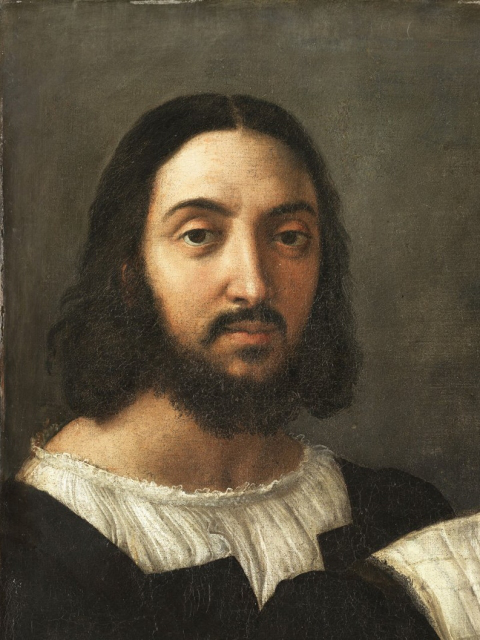

In [0]:
pablo = open_image('/content/gdrive/My Drive/Colab Notebooks/raf-2.jpg')
pablo


посмотрим на чьи произведения больше всего похожа данная картинка

In [0]:
pred_class,pred_idx,outputs = model.predict(pablo)
print(pred_class,outputs[pred_idx]*100)
print(pred_class,pred_idx)
for i in outputs:
  print(i*100)

Titian tensor(44.6808)
Titian tensor(46)
tensor(0.2417)
tensor(0.0049)
tensor(0.0058)
tensor(0.0090)
tensor(0.0014)
tensor(0.3024)
tensor(0.3815)
tensor(0.0458)
tensor(0.0101)
tensor(4.7818)
tensor(0.4118)
tensor(0.4073)
tensor(0.0025)
tensor(0.1286)
tensor(0.1943)
tensor(2.3170)
tensor(0.0491)
tensor(0.0564)
tensor(0.0530)
tensor(0.1419)
tensor(2.6376)
tensor(0.0003)
tensor(0.0162)
tensor(0.0050)
tensor(0.0246)
tensor(0.0323)
tensor(0.7054)
tensor(0.0004)
tensor(0.4537)
tensor(0.7422)
tensor(0.0113)
tensor(0.0229)
tensor(0.3619)
tensor(0.1222)
tensor(0.0404)
tensor(0.4364)
tensor(0.0096)
tensor(1.0116)
tensor(0.1369)
tensor(0.0081)
tensor(0.3053)
tensor(9.1693)
tensor(28.6914)
tensor(0.0069)
tensor(0.0659)
tensor(0.5450)
tensor(44.6808)
tensor(0.0018)
tensor(0.2006)
tensor(0.0078)


Возьмем топ-3 по совпадениям

In [0]:
val,idd=outputs.topk(3)
print('this is ',int(idd[0]),' percent=',val[0]*100)


this is  46  percent= tensor(44.6808)


Подгрузим файл с описанием

In [0]:
import pandas as pd
wiki = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/res.csv')

Сформируем строку, котороую будем выводить в сообщение 

In [0]:
mess_='Стиль данной картины похож: \n'
# val_, id_=pred_[2].topk(3)
for i in range(0,3):
# 		print(int(idd[i]))
    pain_=wiki[wiki['count']==int(idd[i])].name.values[0]
    percent_=int(val[i]*100)
    mess_+=str(pain_)+' '+str(percent_)+'%\n' 
    
print(mess_)


Стиль данной картины похож: 
Titian 44%
Rembrandt 28%
Raphael 9%



Просто картинка

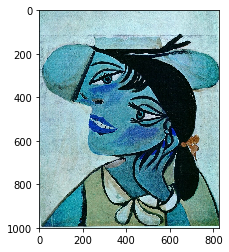

In [0]:
plt.imshow(img)